beta = 2.0, plaq = 0.1256768209181341, acceptance = 0.974
beta = 2.7777777777777777, plaq = 0.1853235548530472, acceptance = 0.956
beta = 3.5555555555555554, plaq = 0.2566330536886428, acceptance = 0.9295
beta = 4.333333333333334, plaq = 0.3380204039688814, acceptance = 0.894
beta = 5.111111111111111, plaq = 0.5047446995458889, acceptance = 0.877
beta = 5.888888888888889, plaq = 0.6074959766799034, acceptance = 0.806
beta = 6.666666666666667, plaq = 0.6655826906089864, acceptance = 0.723
beta = 7.444444444444445, plaq = 0.7045544115843748, acceptance = 0.6525
beta = 8.222222222222221, plaq = 0.737416485718737, acceptance = 0.6035
beta = 9.0, plaq = 0.7641050226745425, acceptance = 0.519


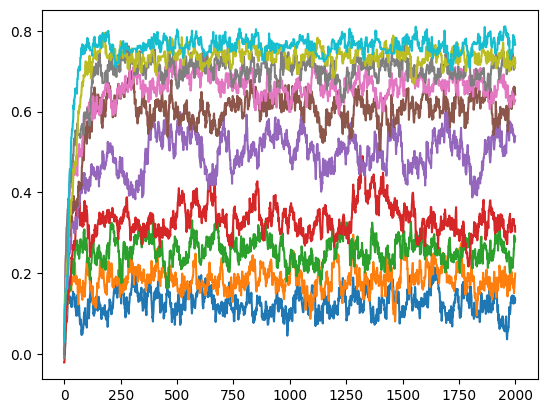

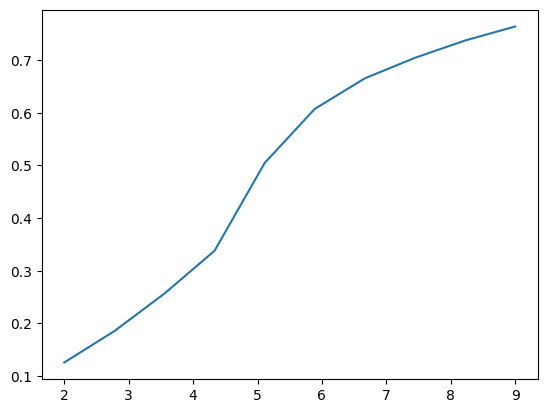

In [1]:
"""
written by Simon Bürger, 2024. Public domain.

This file contains a minimum working implementation of the Hybrid Monte Carlo algorithm
for SU(3) lattice gauge theory. Based on nothing but numpy. This is a didactic example,
very far away from production code.

1) The basic idea is to represent a gauge config as a complex numpy array of shape [4,l,l,l,l,3,3]
   where the first index is Lorentz, the last two are color, and the lattice indices are in between.
   Everything can be handled by numpy/scipy routines.
2) Practically speaking, the most tricky thing in making this work was to fix all the sign conventions
   and factors of 2. I am confident the choices are consistent, as evidenced by the "plaquette vs beta"
   plot in the end. But I am not sure if the conventions here match the GRID library.
3) Some starting points for optimization:
    * Replace "scipy.linalg.expm" with a simple fixed-order Taylor expansion, we dont really need that
      precision here (note: calling 'reunitize' regularly becomes more important when 'exp' becomes more sloppy).
        * Advanced version: Exploit the fact that we are only interested in the exponential of traceless
          anti-hermitian matrices. I guess this should simplify the Taylor series a bit.
        * Even more advanced: Determine the characteristic polynomial of the su(3) matrix explicitly
          (which has a specially simple form for traceless anti-hermitian matrices). Then you can exploit
          the Cayley-Hamilton theorem to write a recursion formula for higher-order terms of the Taylor
          series, where each additional term in the series only costs a few flops, and not a full 3x3
          matrix-matrix multiplication. Sound like fun, though possibly irrelevant for overall performance xD
    * Think hard about the "staple_sum" function. Thats where most flops are spent. Just shuffling around
      the 'cshift's and 'adj's could be useful. If you feel adventurous, this could be the place to
         * write a custom numpy 'ufunc', maybe with a C/C++ backend.
         * add some numba decorator and see what happens
         * something, something, cython. No idea xD. 
    * Numpy defaults to double-precision. Pretty sure at the scale of this code, single-precision
      would be completely sufficient.
    * Better integrator: split each trajectory into smaller substeps, and also replace the leapfrog
      integrator with one of the "minimum norm" method by Omelyan et al. After doing that, you should be 
      able to increase the step-size "eps" quite a bit (while monitoring the acceptance rate).
    * Be careful about distringuishing SU(3) group elements from su(3) algebra elements:
        * su(3) algebra elements should be stored as 8 real numbers (instead of the 9 complex
          numbers used right now). Effectively using some Gell-Mann matrices as a basis.
        * SU(3) group elements should be stored as 6 complex numbers (instead of the 9 used right now).
          This is because the the last row/column is simply the cross-product of the first two. Just
          re-compute it on the fly when needed.
      BTW: This is an optimization that AFAIK is not even done in the GRID library (to be fair:
      while this might be a very nice optimization in a pure-gauge simulation, it is likely irrelevant
      as soon as fermions are involved).
    * Port the whole thing to GPU by replacing "numpy" with "CuPy". In principle this should be
      straightforward. In practice I am sure there is quite some fiddling to do, but it should be doable.

In any case: Have fun :)

"""

import numpy as np
import scipy
import matplotlib.pyplot as plt


# gauge field shape [4,l,l,l,l,3,3]
def reunitize(U):
    """
    project back to the SU(3) color group, inplace.
    Used to occasionally correct rounding errors, and used for generating random SU(3) gauge configs.
    """
    assert isinstance(U, np.ndarray)
    assert U.shape[-2:] == (3, 3)
        
    c0 = U[..., 0]
    c1 = U[..., 1]
    c2 = U[..., 2]

    # Gram-Schmidt first two vectors, directly recompute the third
    c0 /= np.linalg.norm(c0, axis=-1, keepdims=True)
    c1 -= np.einsum("...i,...i,...k->...k", c0.conj(), c1, c0)
    c1 /= np.linalg.norm(c1, axis=-1, keepdims=True)
    c2[:] = np.cross(c0, c1).conj()

def adj(U):
    """ adjoint in color space """
    assert isinstance(U, np.ndarray)    
    assert U.shape[-2:] == (3, 3)
    return U.swapaxes(-1, -2).conj()

def trace(U):
    """ trace over color matrices"""
    assert isinstance(U, np.ndarray)
    assert U.shape[-2:] == (3, 3)
    return np.trace(U, axis1=-1, axis2=-2)

def exp(A):
    """ matrix exponential. intended for su(3) algebra -> SU(3) group """
    assert isinstance(A, np.ndarray)
    assert A.shape[-2:] == (3, 3)
    return scipy.linalg.expm(A)

def random_su3_config(grid):
    """ generate a random SU(3) gauge field """
    # Idea: sample each component of 3x3 matrix independently from a complex normal
    # distribution, then reunitize. It is not obvious that this actually generates
    # a uniform distribution on SU(3), and it definitely depends on how exactly
    # the reunitize function is implemented. I'm like 90% sure that this current
    # version is correct but it's not really important anyway because its only used
    # as a starting point for the HMC algorithm.
    shape = [len(grid), *grid, 3, 3]
    f = np.random.randn(*shape) + 1j * np.random.randn(*shape)
    reunitize(f)
    return f

def random_su3_algebra(grid):
    """ generate a random SU(3) algebra element (traceless-anti-hermitian matrices) """
    shape = [len(grid), *grid, 3, 3]
    f = np.random.randn(*shape) + 1j * np.random.randn(*shape)
    # beware of the sqrt(1/2) normalization factor. If you change this, you need
    # to compensate in the definition of the conjugate momentum in the HMC algorithm.
    return anti_hermitian_traceless(f)*0.5**0.5

def unit_config(grid):
    """ generate a unit SU(3) gauge field """
    shape = [len(grid), *grid, 3, 3]
    f = np.eye(3) + 0j
    return np.broadcast_to(f, shape)

def anti_hermitian_traceless(U): # in grid, this is called "Ta(...)"
    """ project to the space of anti-hermitian traceless matrices """
    assert isinstance(U, np.ndarray)
    assert U.shape[-2:] == (3, 3)

    r = 0.5 * (U-adj(U)) # make it anti-hermitian
    r -= 1/3 * trace(r)[..., np.newaxis, np.newaxis] * np.eye(3) # make it traceless
    return r

def is_config(U):
    return isinstance(U, np.ndarray) and U.ndim == 7 and U.shape[0] == 4 and U.shape[-2:] == (3, 3) 

def cshift(U, mu, shift):
    """ this cshift(...) function has the same sign conventions as the cshift function in GRID """
    return np.roll(U, -shift, axis=mu)

def staple_sum(U, mu):
    """ sum over 6 staples connected to a single link """
    assert is_config(U)

    r = np.zeros_like(U[0])
    for nu in range(4):
        if nu == mu:
            continue
        # sum "backwards" and "forwards" staples.
        # NOTE: In a pure-gauge simulation, most computing time is typcially spent in 'staple_sum'.
        # So optimizing the next two lines would be quite crucial
        r += cshift(U[nu], mu, 1) @ adj(cshift(U[mu], nu, 1)) @ adj(U[nu])
        r += cshift(adj(cshift(U[nu], mu, 1)) @ adj(U[mu]) @ U[nu], nu, -1)
    #print(r.shape)
    return r

def plaquette(U):
    """ normalized to [0,1] (or strictly speaking [-1,1] ?) """
    # for testing: make sure that plauqette(unit_config) = 1 (exactly),
    # and plaquette(random_config) = 0 (approximately)
    assert is_config(U)
    volume = np.prod(U.shape[1:-2])
    #print(f"volume = {volume}")
    s = 0.0
    for mu in range(4):
        s += trace(U[mu] @ staple_sum(U, mu)).real.sum()
    return s / (volume*6*3*4)
    

def wilsonAction(U, beta):
    """
    evaluate the Wilson plaquette action, that is typially written as
    S = beta/6 * sum_{plaquettes} (1 - Re Tr U_p)
    where beta=6/g^2, and g is the coupling constant.
    For tests, the typical benchmarking point in the literature is beta=6
    """
    assert is_config(U)
    volume = np.prod(U.shape[1:-2])
    return (1.0-plaquette(U)) * (beta * 4 * 3 *0.5 * volume)

def wilsonDeriv(U, beta):
    """
    derivative of the Wilson gauge action.
    Note that this returns element in the su(3) algebra (traceless anti-hermitian matrices)
    """
    assert is_config(U)
    volume = np.prod(U.shape[1:-2])
    r = np.zeros_like(U)
    for mu in range(4):
        r[mu] = (beta/6)*anti_hermitian_traceless(U[mu]@staple_sum(U,mu))
    return r


def run_hmc(U, eps, beta, nsteps):
    """
    run the Hybrid Monte Carlo algorithm for a given number of steps with the Wilson gauge action.
    U is modified in place.
    """
    assert is_config(U)
    shape = U.shape
    grid = shape[1:-2]
    assert len(grid) == 4
    r = {}
    r["plaq_history"] = []
    r["accept_history"] = []
    r["deltaH_history"] = []

    for i in range(nsteps):
        # random momentum
        P = random_su3_algebra(grid)
        H_old = wilsonAction(U, beta=beta) +  np.linalg.norm(P)**2
            
        # leapfrog algorithm
        # ( in production code, this trajectory of length "eps" should be subdivided into smaller steps here)
        U2 = exp(-0.5*eps*P) @ U
        P += eps * wilsonDeriv(U2, beta)
        U2 = exp(-0.5*eps*P) @ U2
        
        # project back to SU(3) group
        # (this only removes rounding errors, so doing this every step is definitely overkill)
        reunitize(U2)

        H_new = wilsonAction(U2, beta=beta) +  np.linalg.norm(P)**2
        
        # metropolos accept/reject step
        deltaH = H_new - H_old
        if np.random.rand() < np.exp(-deltaH):
            r["accept_history"].append(1)
            U[:] = U2[:]
        else:
            r["accept_history"].append(0)


        r["plaq_history"].append(plaquette(U))
        r["deltaH_history"].append(deltaH)
    return r


# Test case: tiny 2x2x2x2 lattice, simulating at various values of beta.
# plotting average plaquette vs beta should yield a characteristic curve that
# can be compared to plots from the literature (at least Gattringer contains pretty much this plot)
# Note: on my laptop, this exact script takes about 2 minutes to run, already
# with this tiny 2^4 lattice. Exercise for the reader: optimize this code (without
# leaving numpy as a backend), to make a 4^4 lattice just as fast as the 2^4 is right now.

grid = [2,2,2,2]
shape = [4,*grid,3,3]
eps = 0.2
xs = []
ys = []

for beta in np.linspace(2.0, 9.0, 10):

    # If the HMC is run long enough, the initial config does not matter of course.
    # Practucally speaking, the common choices are:
    U = random_su3_config(grid) # "hot start"
    # U = unit_config(grid) # "cold start"
    
    r = run_hmc(U=U, eps=eps, beta=beta, nsteps=2000)

    plaq = r["plaq_history"]
    plaq = plaq[len(plaq)//4:] # skip the first quarter of the samples to avoid thermalization phase
    plaq = np.mean(plaq)

    print("beta = {}, plaq = {}, acceptance = {}".format(beta, np.mean(plaq), np.mean(r["accept_history"])))

    plt.plot(r["plaq_history"])
    xs.append(beta)
    ys.append(np.mean(plaq))

plt.figure()
plt.plot(xs, ys)
